# Working with BFL FLUX in Pixeltable

This notebook demonstrates how to use Black Forest Labs (BFL) FLUX models for image generation and editing through Pixeltable.

[BFL FLUX](https://docs.bfl.ai/) offers state-of-the-art text-to-image generation with models like FLUX.2 and FLUX 1.1, featuring:

- High-fidelity image generation with accurate hands, faces, and textures
- Multi-reference image editing
- Precise hex color control
- Typography and text rendering

## Prerequisites

1. A BFL API key from [dashboard.bfl.ai](https://dashboard.bfl.ai)
1. Pixeltable installed

## Setup

First, install Pixeltable and set up your API key:

In [ ]:
%pip install -qU pixeltable

In [2]:
import os
import getpass

# Set your BFL API key - get one from https://dashboard.bfl.ai
if 'BFL_API_KEY' not in os.environ:
    os.environ['BFL_API_KEY'] = getpass.getpass(
        'Enter your BFL API key: '
    )

In [3]:
import pixeltable as pxt
from pixeltable.functions import bfl

# Create a directory for our examples
pxt.drop_dir('bfl_demo', force=True)
pxt.create_dir('bfl_demo')

Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/pjlb/.pixeltable/pgdata
Created directory 'bfl_demo'.


## Text-to-Image Generation

Generate images from text prompts using FLUX models. FLUX 1.1 [pro] offers fast, reliable results.

In [4]:
# Create a table for image generation
prompts_t = pxt.create_table(
    'bfl_demo.prompts',
    {'prompt': pxt.String, 'style': pxt.String},
    if_exists='replace',
)

# Add a computed column that generates images from prompts
prompts_t.add_computed_column(
    image=bfl.generate(
        prompts_t.prompt, model='flux-pro-1.1', width=1024, height=1024
    )
)

Created table 'prompts'.
Added 0 column values with 0 errors.


No rows affected.

In [5]:
# Insert some prompts to generate images
prompts_t.insert(
    [
        {
            'prompt': 'A majestic mountain landscape at golden hour, photorealistic',
            'style': 'landscape',
        },
        {
            'prompt': 'A futuristic city with flying cars and neon lights, cyberpunk style',
            'style': 'sci-fi',
        },
    ]
)

Inserting rows into `prompts`: 2 rows [00:00, 442.18 rows/s]
Inserted 2 rows with 0 errors.


2 rows inserted, 6 values computed.

prompt  \
0  A majestic mountain landscape at golden hour, ...   
1  A futuristic city with flying cars and neon li...   

                                               image  
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...
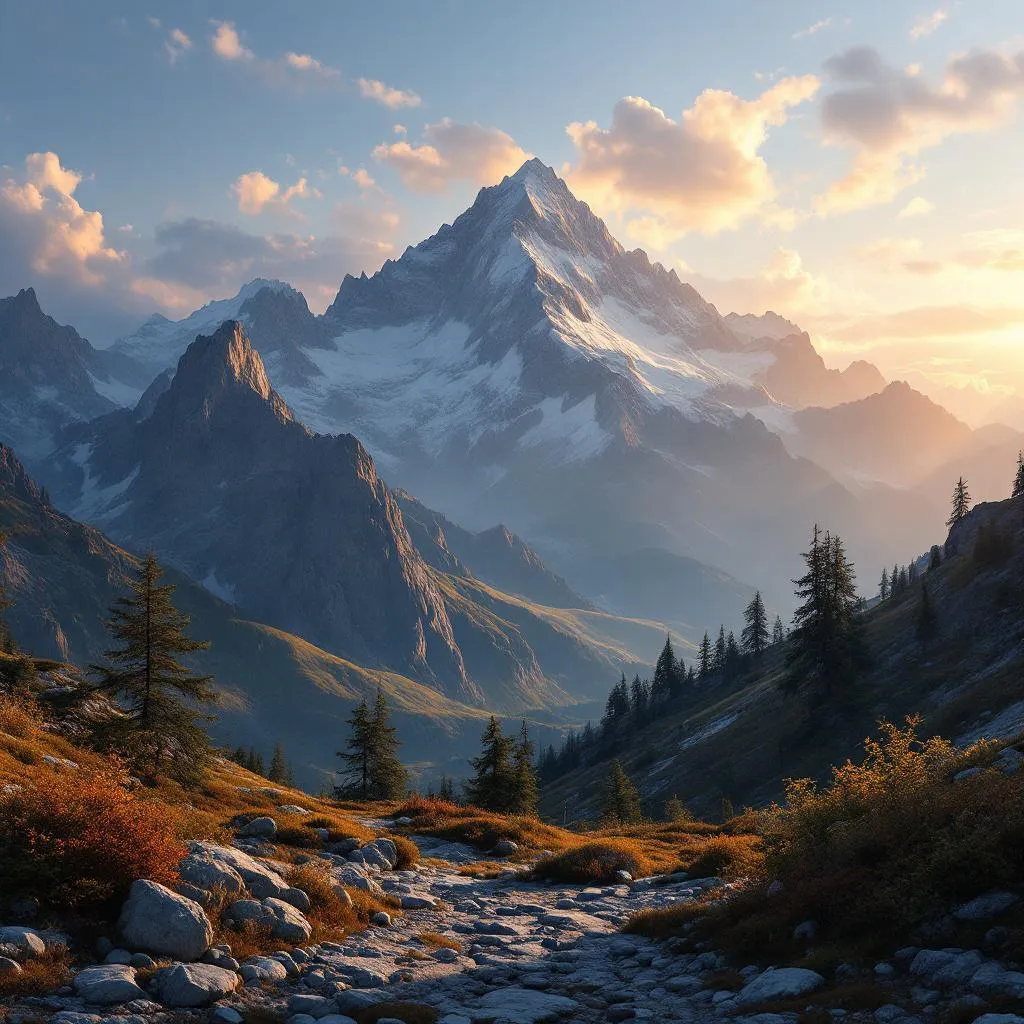
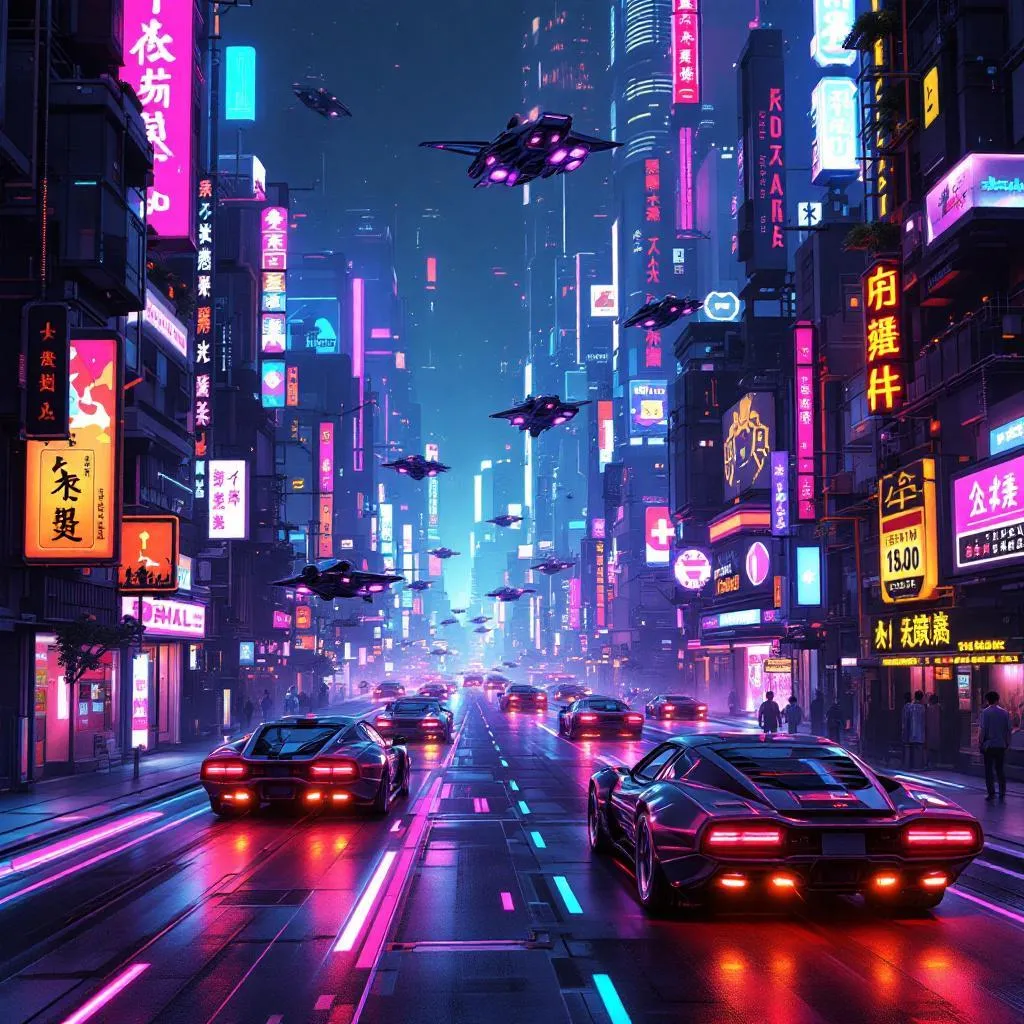

In [6]:
# View the generated images
prompts_t.select(prompts_t.prompt, prompts_t.image).show()

## Image Editing

Edit existing images with text prompts using FLUX models. This is powerful for:

- Changing backgrounds
- Adding or removing objects
- Style transfer
- Multi-reference editing

In [7]:
# Create a table for image editing
edit_t = pxt.create_table(
    'bfl_demo.edits',
    {'original': pxt.Image, 'edit_prompt': pxt.String},
    if_exists='replace',
)

# Add computed column for edited images
edit_t.add_computed_column(
    edited=bfl.edit(
        edit_t.edit_prompt, edit_t.original, model='flux-2-pro'
    )
)

Created table 'edits'.
Added 0 column values with 0 errors.


No rows affected.

In [ ]:
# Insert an image and edit prompt
# Replace with your own image URL or path
edit_t.insert(
    original='https://images.unsplash.com/photo-1506744038136-46273834b3fb?w=1024&h=768&fit=crop',
    edit_prompt='Add a dramatic sunset with vibrant orange and purple colors',
)

Inserting rows into `edits`: 1 rows [00:00, 600.99 rows/s]
Inserted 1 row with 0 errors.


1 row inserted, 4 values computed.

original  \
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                              edited  \
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                         edit_prompt  
0  Add a dramatic sunset with vibrant orange and ...
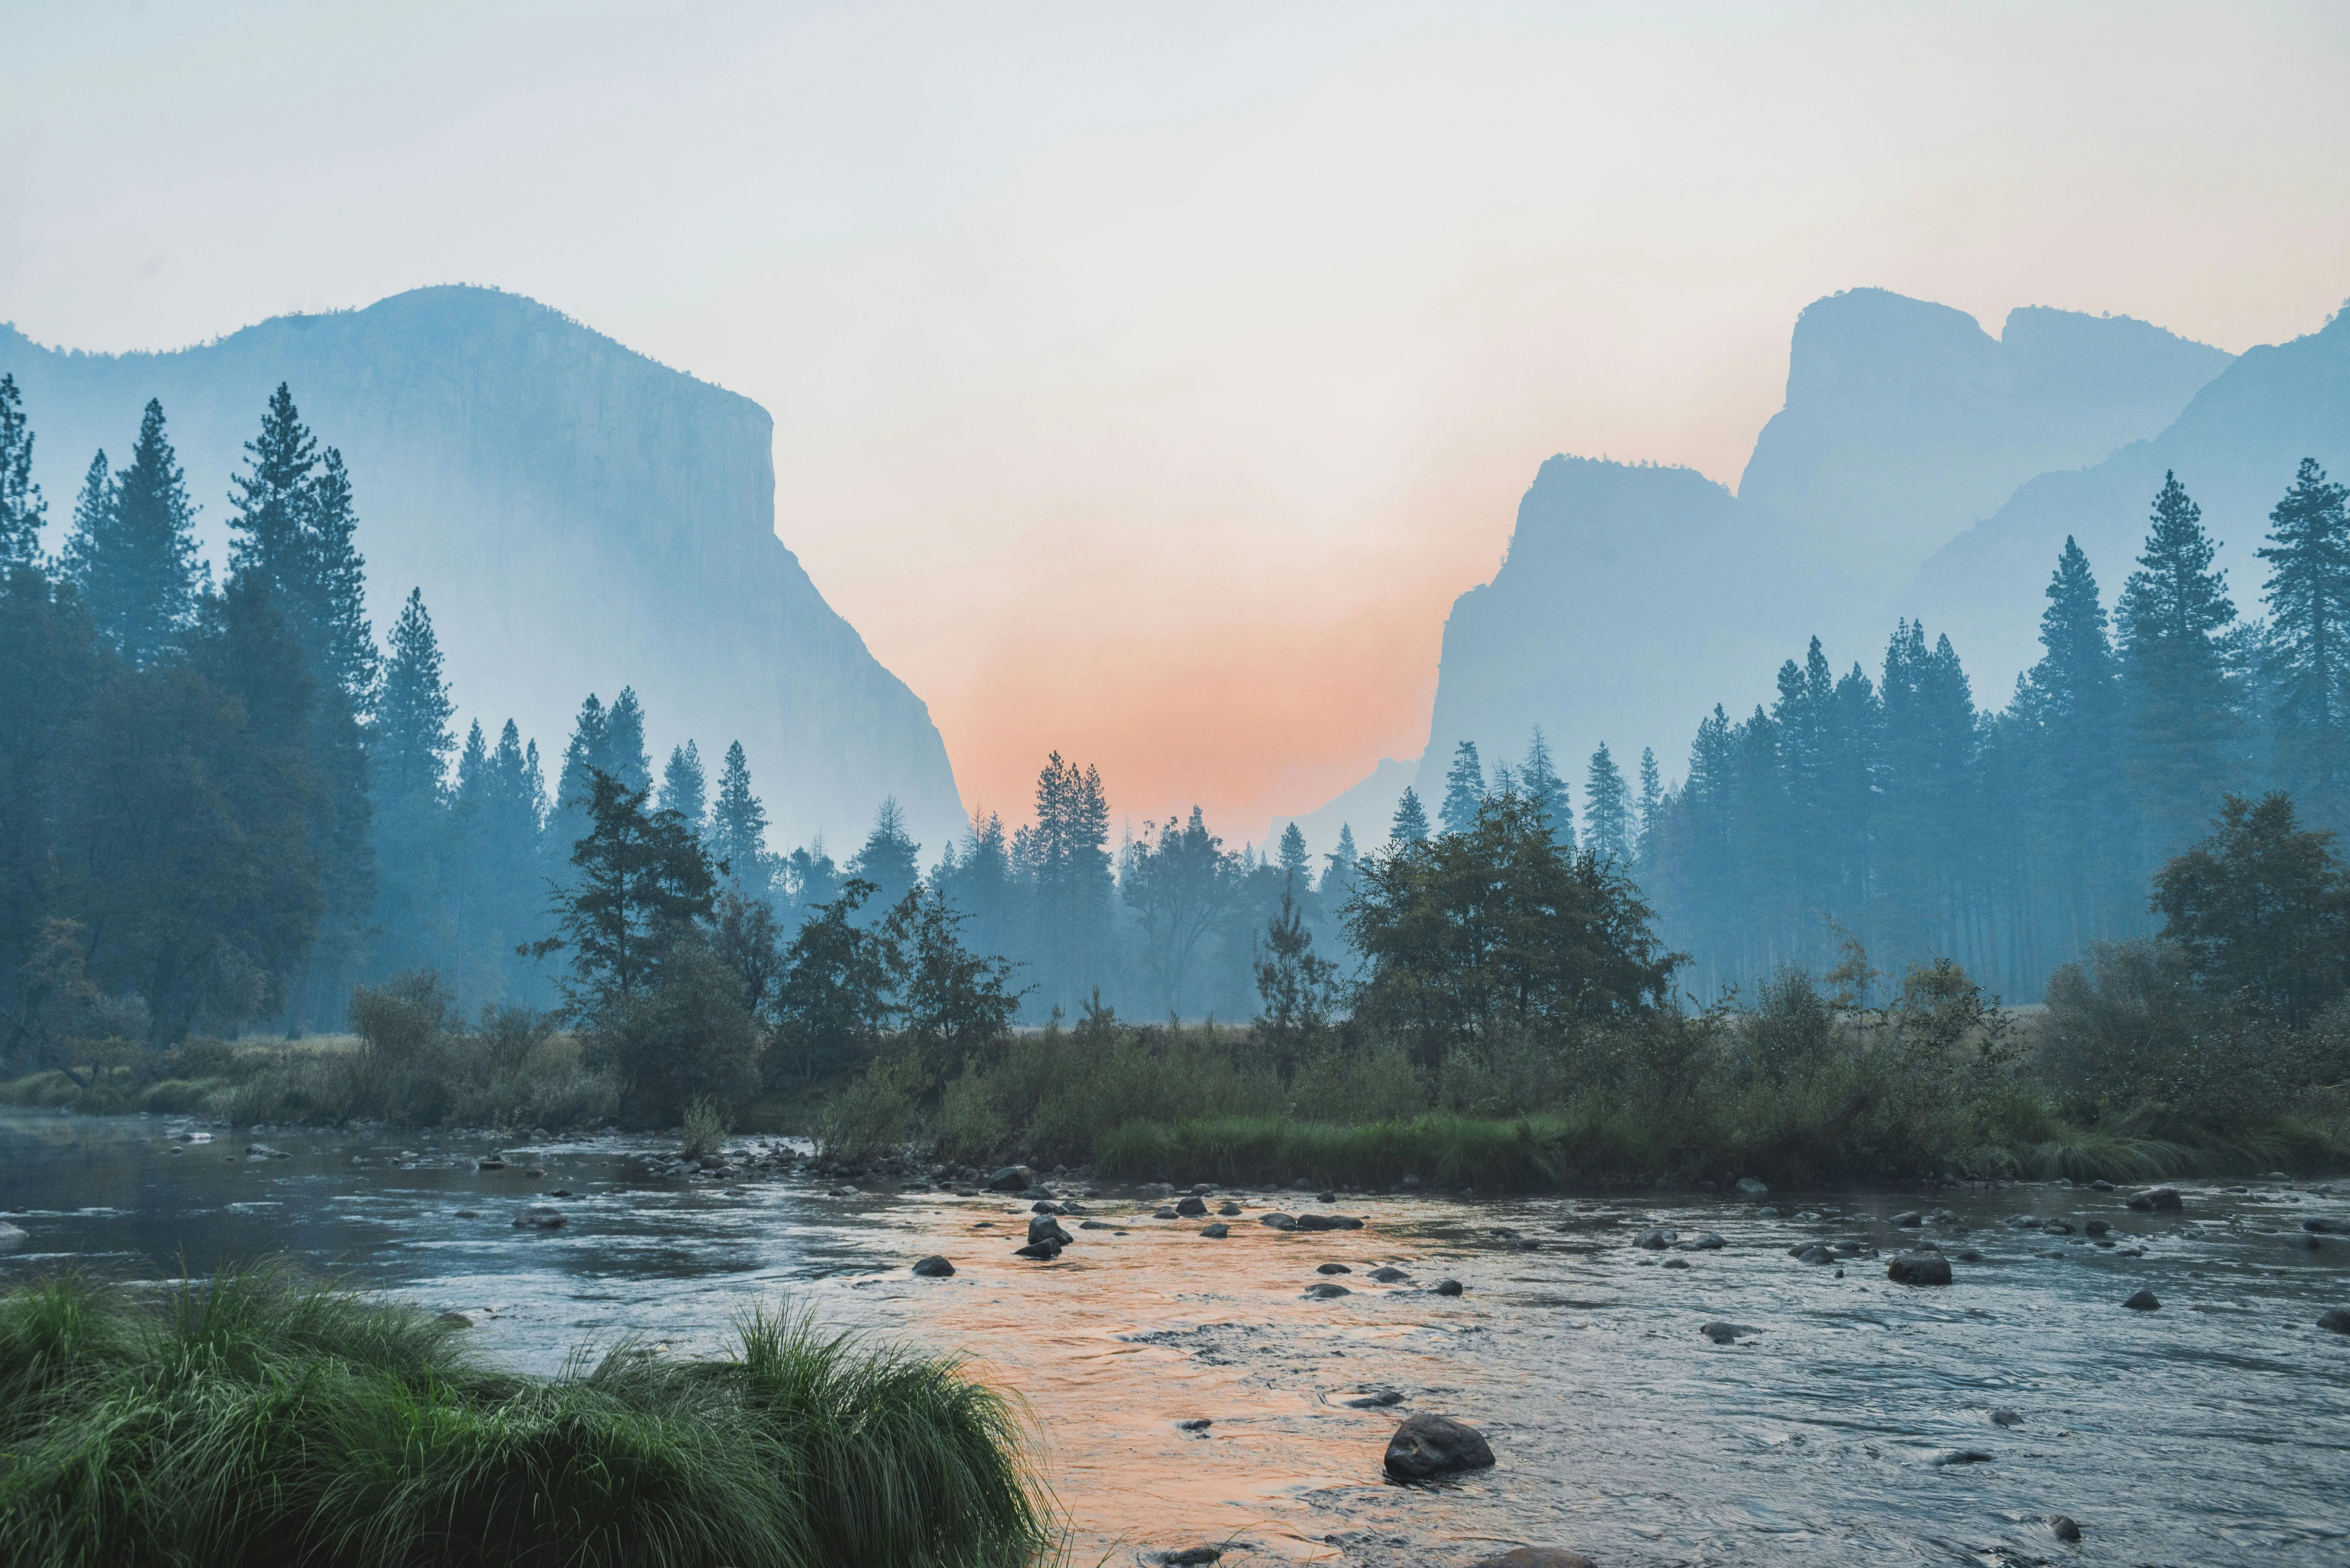
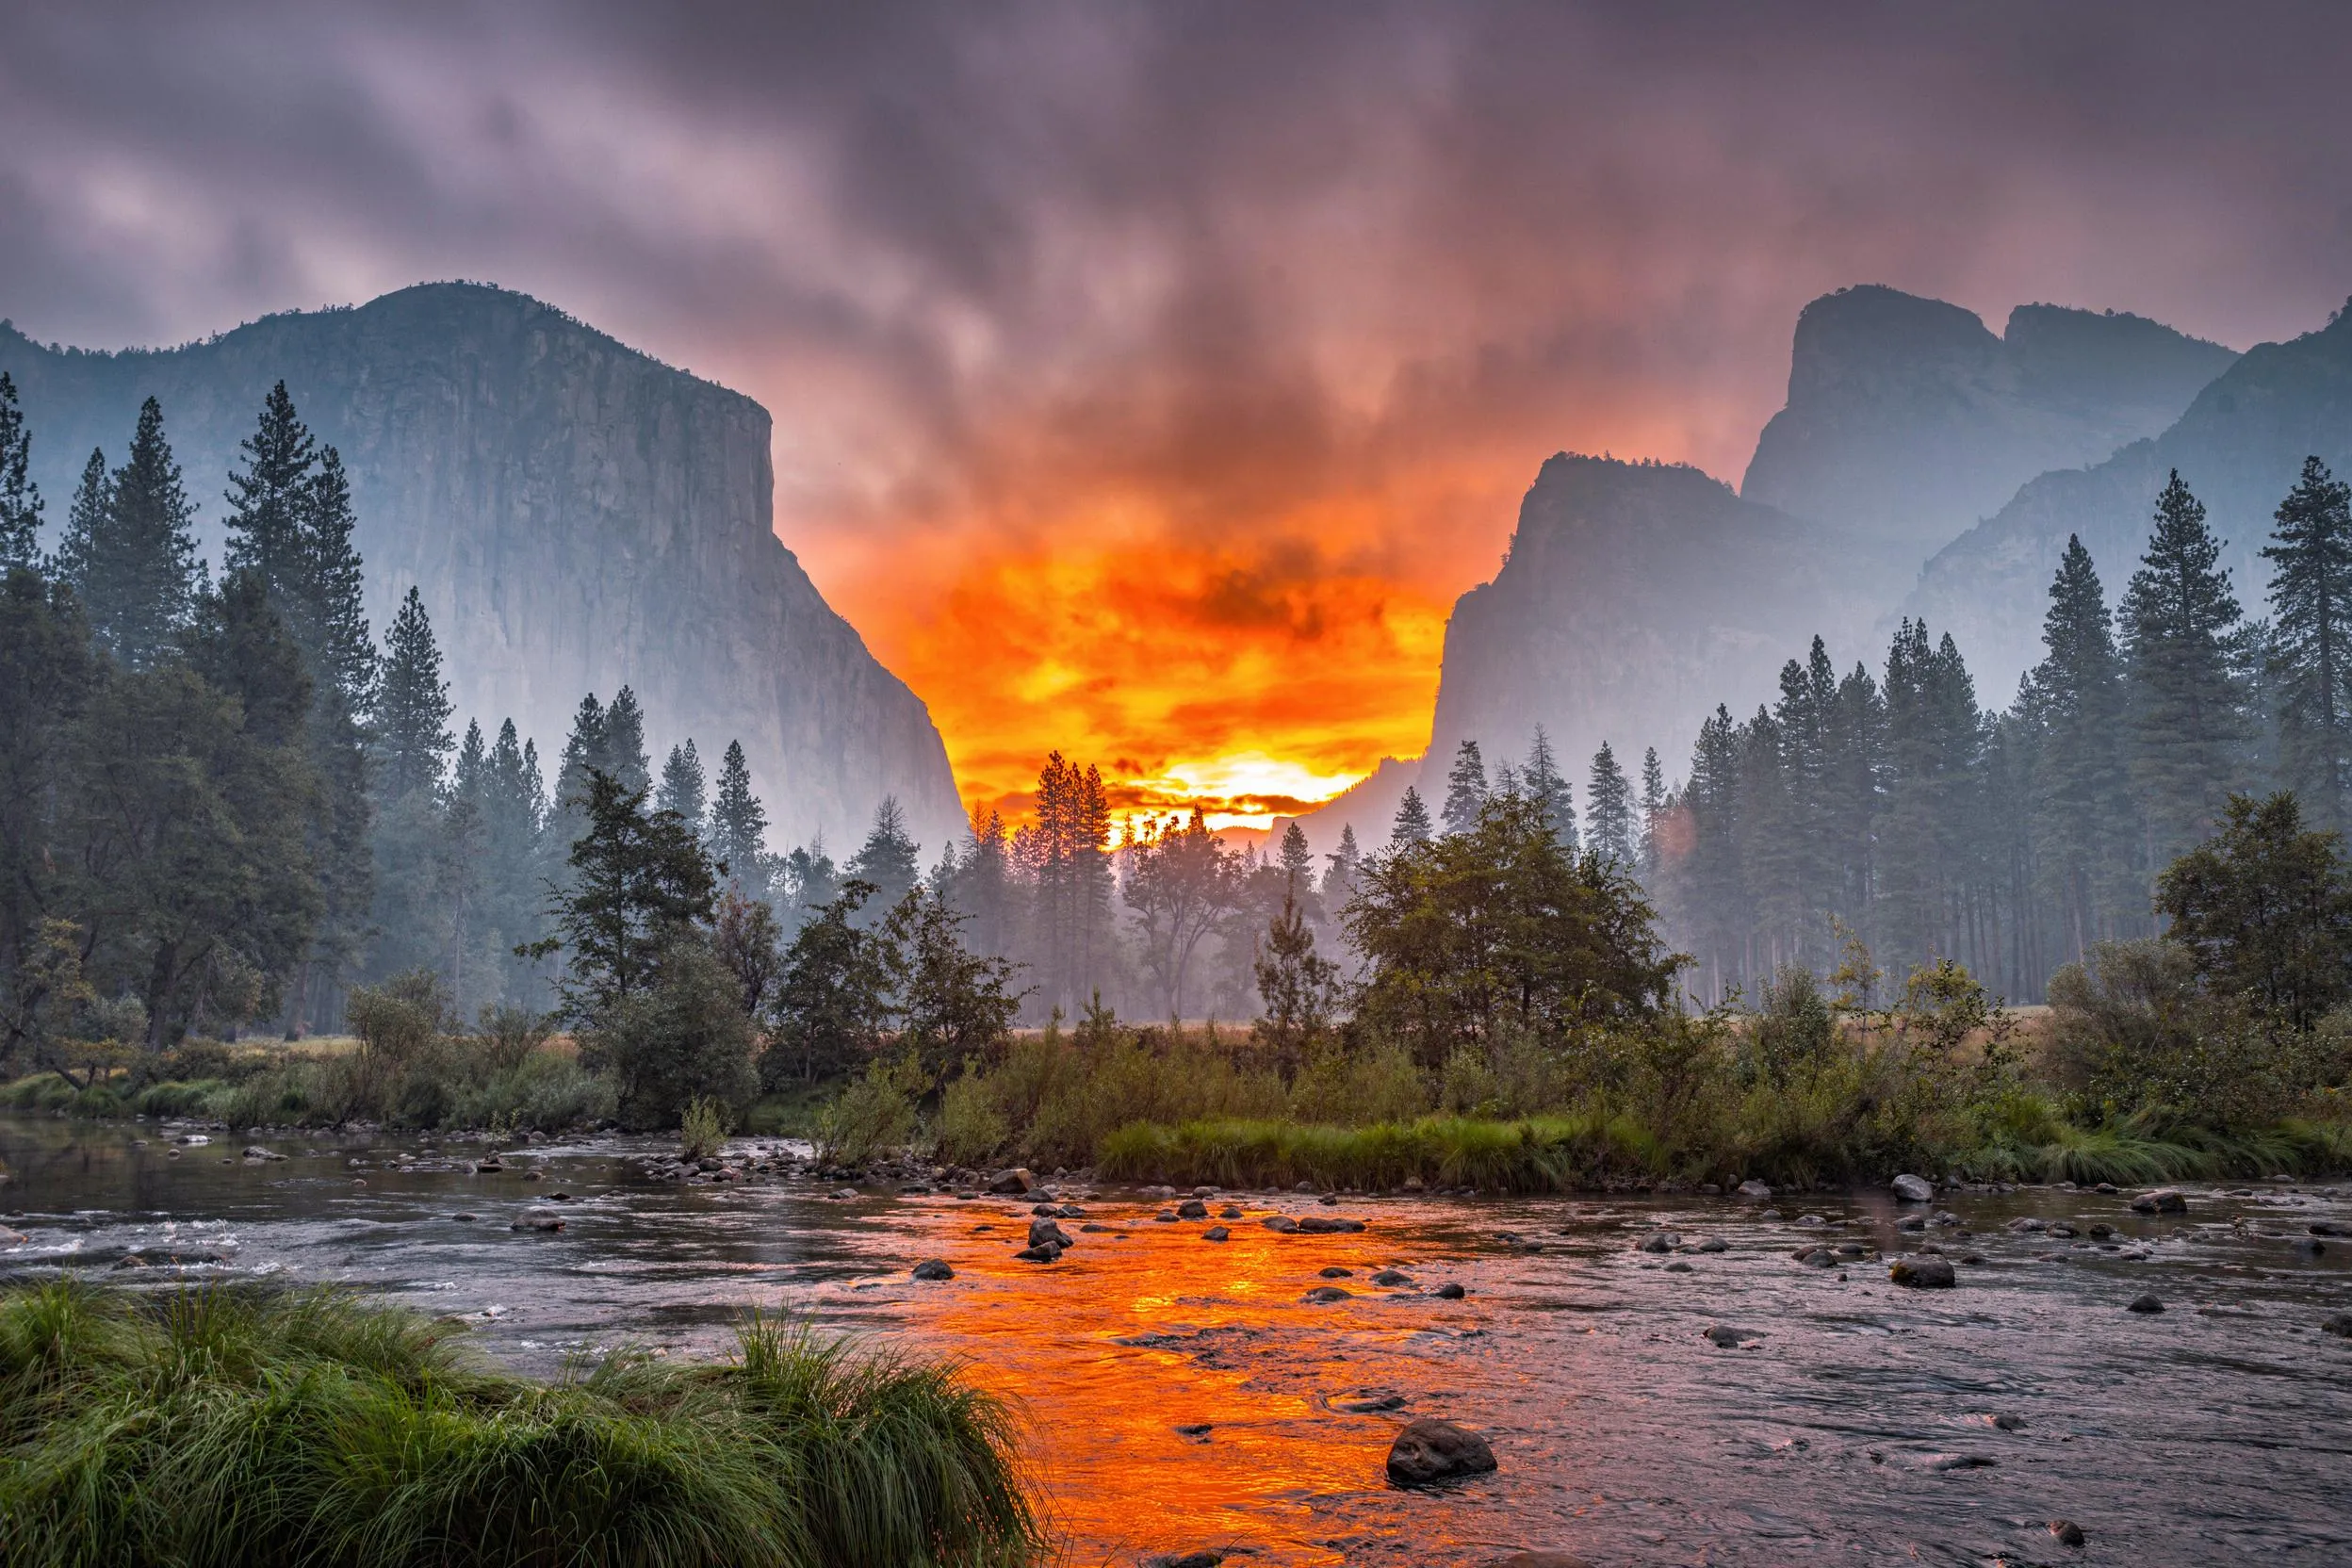

In [9]:
# View original and edited images
edit_t.select(edit_t.original, edit_t.edited, edit_t.edit_prompt).show()

## Using Seeds for Reproducibility

Use the `seed` parameter to get reproducible results:

In [10]:
# Create a table with seed support
seed_t = pxt.create_table(
    'bfl_demo.seeded',
    {'prompt': pxt.String, 'seed': pxt.Int},
    if_exists='replace',
)

seed_t.add_computed_column(
    image=bfl.generate(
        seed_t.prompt,
        model='flux-pro-1.1',
        width=512,
        height=512,
        seed=seed_t.seed,
    )
)

# Same seed = same image
seed_t.insert(
    [
        {'prompt': 'A red rose in a crystal vase', 'seed': 42},
        {
            'prompt': 'A red rose in a crystal vase',
            'seed': 42,
        },  # Same result
        {
            'prompt': 'A red rose in a crystal vase',
            'seed': 123,
        },  # Different result
    ]
)

Created table 'seeded'.
Added 0 column values with 0 errors.


Inserting rows into `seeded`: 3 rows [00:00, 1211.18 rows/s]
Inserted 3 rows with 0 errors.


3 rows inserted, 6 values computed.

prompt  seed  \
0  A red rose in a crystal vase    42   
1  A red rose in a crystal vase   123   
2  A red rose in a crystal vase    42   

                                               image  
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...
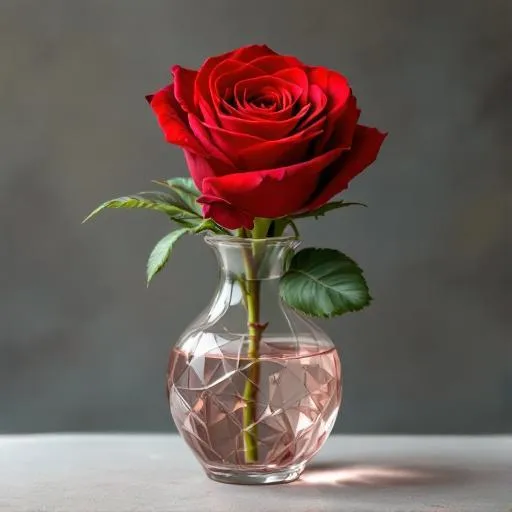
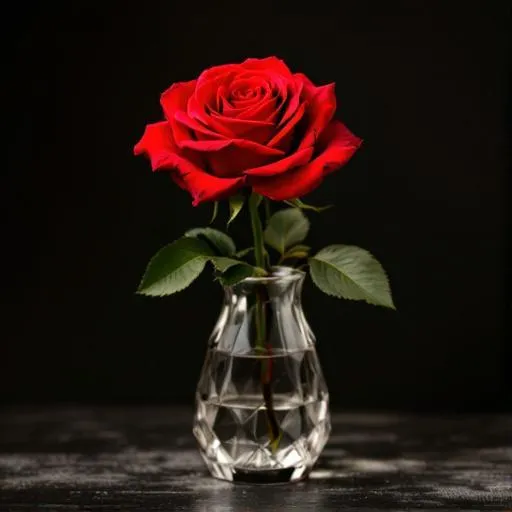
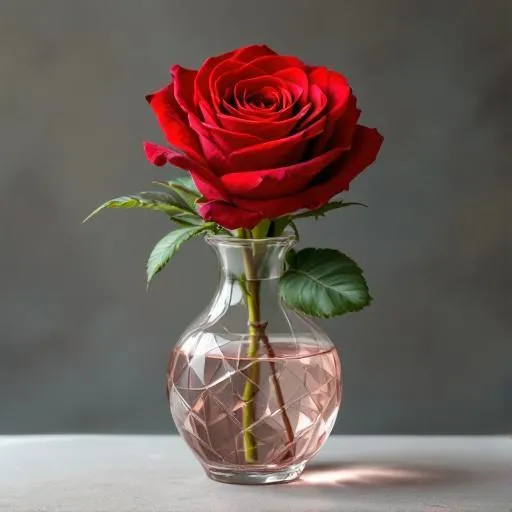

In [11]:
seed_t.collect()

## Image Expansion (Outpainting)

Expand an image beyond its original boundaries using `bfl.expand()`. This is perfect for:

- Making images wider or taller
- Adapting content for different aspect ratios
- Extending scenes naturally

In [12]:
# Create a table for image expansion
expand_t = pxt.create_table(
    'bfl_demo.expanded',
    {'image': pxt.Image, 'expand_prompt': pxt.String},
    if_exists='replace',
)

# Add computed column to expand images horizontally
expand_t.add_computed_column(
    wide=bfl.expand(
        expand_t.expand_prompt,
        expand_t.image,
        left=256,  # Add 256 pixels to left
        right=256,  # Add 256 pixels to right
    )
)

Created table 'expanded'.
Added 0 column values with 0 errors.


No rows affected.

In [15]:
# Insert an image to expand - using a known small image
expand_t.insert(
    image='https://replicate.delivery/pbxt/HtGQBfA5TrqFYZBf0UL18NTqHrzt8UiSIsAkUuMHtjvFDO6p/overture-creations-5sI6fQgYIuo.png',
    expand_prompt='Continue the room interior with similar decor and lighting',
)

Inserting rows into `expanded`: 1 rows [00:00, 379.78 rows/s]
Inserted 1 row with 0 errors.


1 row inserted, 4 values computed.

image  \
0  <PIL.PngImagePlugin.PngImageFile image mode=RG...   

                                                wide  
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...
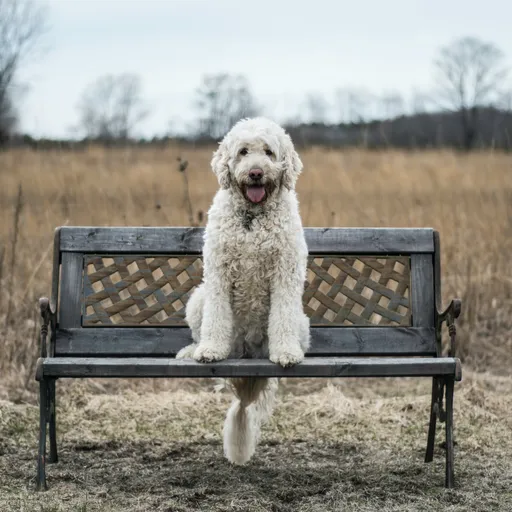
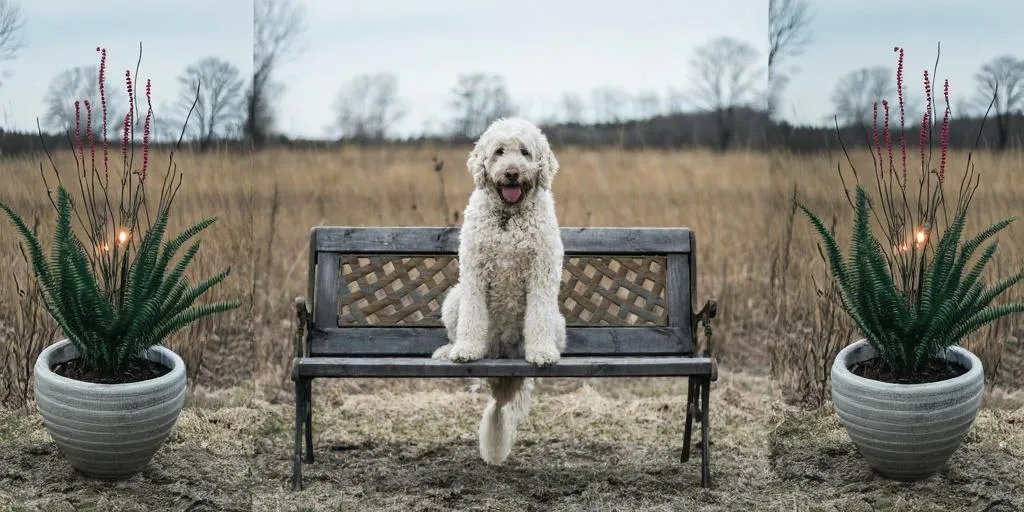

In [16]:
# View original and expanded images
expand_t.select(expand_t.image, expand_t.wide).show()

## Inpainting with Fill

`bfl.fill()` allows you to inpaint specific regions of an image using a mask:

- **Black areas** in the mask are preserved
- **White areas** in the mask are inpainted based on the prompt

Use cases: remove unwanted objects, replace backgrounds, edit text in images, restore damaged areas.

In [17]:
# Create a table for inpainting
fill_t = pxt.create_table(
    'bfl_demo.filled',
    {'image': pxt.Image, 'mask': pxt.Image, 'fill_prompt': pxt.String},
    if_exists='replace',
)

# Add computed column to fill masked regions
fill_t.add_computed_column(
    filled=bfl.fill(
        fill_t.fill_prompt,
        fill_t.image,
        fill_t.mask,
        steps=50,
        guidance=30,
    )
)

Created table 'filled'.
Added 0 column values with 0 errors.


No rows affected.

In [18]:
# Insert image and mask - the white area in the mask will be inpainted
fill_t.insert(
    image='https://replicate.delivery/pbxt/HtGQBfA5TrqFYZBf0UL18NTqHrzt8UiSIsAkUuMHtjvFDO6p/overture-creations-5sI6fQgYIuo.png',
    mask='https://replicate.delivery/pbxt/HtGQBqO9MtVbPm0G0K43nsvvjBB0E0PaWOhuNRrRBBT4ttbf/mask.png',
    fill_prompt='A fluffy golden retriever sitting on the couch',
)

Inserting rows into `filled`: 1 rows [00:00, 531.87 rows/s]
Inserted 1 row with 0 errors.


1 row inserted, 6 values computed.

image  \
0  <PIL.PngImagePlugin.PngImageFile image mode=RG...   

                                                mask  \
0  <PIL.PngImagePlugin.PngImageFile image mode=RG...   

                                              filled  
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...
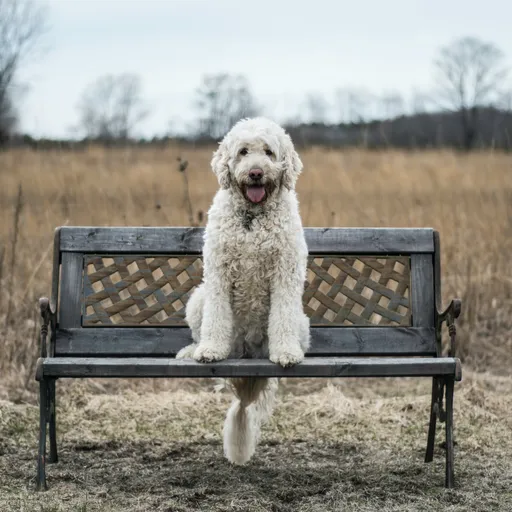
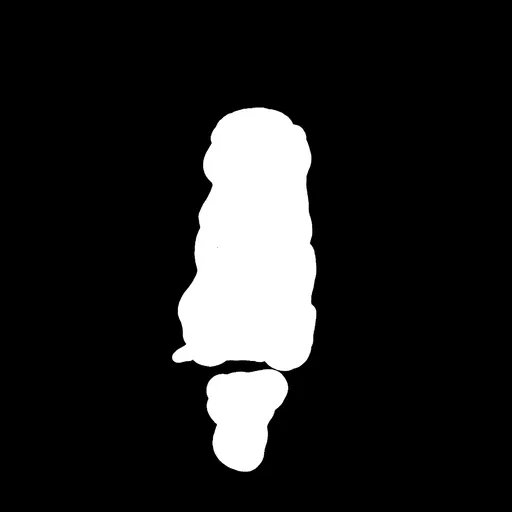
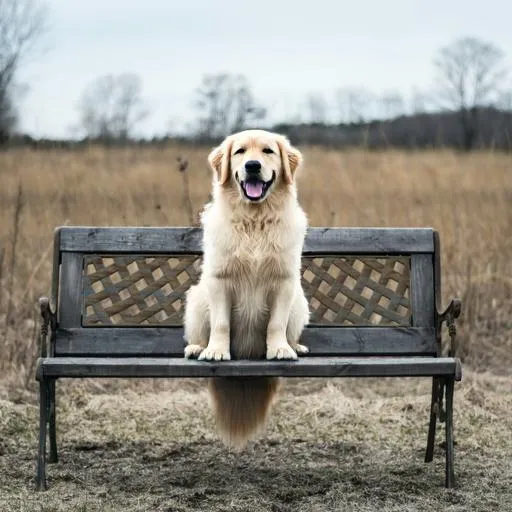

In [19]:
# View original image, mask, and filled result
fill_t.select(fill_t.image, fill_t.mask, fill_t.filled).show()

## Best Practices

1. **Use specific prompts**: Include details about style, lighting, composition, and subject
1. **Start with flux-pro-1.1**: Fast and reliable for most use cases
1. **Use seeds for reproducibility**: When you need consistent results
1. **Resolution**: Minimum 64x64, max 4MP (2048x2048), dimensions must be multiples of 16
1. **Input image limits**: Max 20MP for editing/expand/fill operations
1. **Safety tolerance**: Default is 2; lower = stricter moderation (0-6 scale)

## Learn More

- [BFL Documentation](https://docs.bfl.ai/)
- [FLUX.2 Overview](https://docs.bfl.ai/flux_2/flux2_overview)
- [Text-to-Image API](https://docs.bfl.ai/flux_2/flux2_text_to_image)
- [Image Editing API](https://docs.bfl.ai/flux_2/flux2_image_editing)
- [Pricing](https://docs.bfl.ai/quick_start/pricing)